## Objective:

*Whilst working on the task of image segmentation, one aspect I was confronted with involved adding some custom edits to the model in order to reduce overall parameter count or improve performance. Random addition of extra parameters didn't help my case, and that brough me into the area of understanding the role of the convolutional layers present in the network.*

*To that end, I scripted code to help me visualize the feature maps of the convolutional layers in a network. As an example, we will be going to be using the visualizer on the DeeplabV3 model. The model code is obtained from the following GitHub repository: https://github.com/VainF/DeepLabV3Plus-Pytorch*


In [29]:
#imports
import network
import torchvision.transforms as transform
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [30]:
##Model Loading
model = network.modeling.__dict__["deeplabv3plus_mobilenet"](num_classes=151,output_stride=8).to("cuda")
ckpt = torch.load( "deeplabv3plus",map_location="cpu")
model.load_state_dict(ckpt['state_dict'])
model.eval()
del ckpt

In [55]:
#labels to rgb -- for visualizing the Ground Truth
def lab_to_map(x,N=151):

  
   cmap_dict = {}
   np.random.seed(0)
   for i in range(N):
      if i != 0: 
         cmap_dict[i] = tuple(np.random.randint(256, size=3))
      
   h,w = x.shape
  
   mask = np.zeros((h,w,3),dtype=np.uint8)
   for label,rgb in cmap_dict.items():
      mask[x==label,:] = rgb
   
   return mask
   

*Since the model is trained on the ADE20k dataset, we will be using an example image from that dataset*

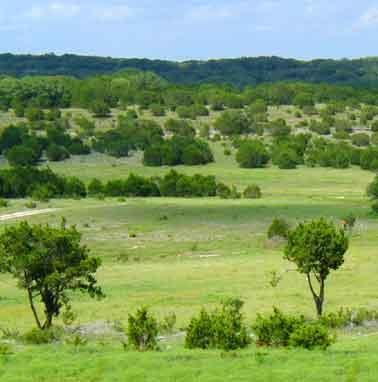

In [32]:
##Loading the Image

img = Image.open("ADE_train_00007822.jpg")
img.show()


image_transform = transform.Compose([transform.ToTensor(),
        transform.Normalize(mean=(0.48897024, 0.46548376, 0.42939524), std=(0.25883686, 0.25581116, 0.27494394))
        ])
img_tensor = image_transform(img).to("cuda")
img_tensor = img_tensor.unsqueeze(0)


Predicted Mask: 


/tmp/ipykernel_46767/1901739001.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


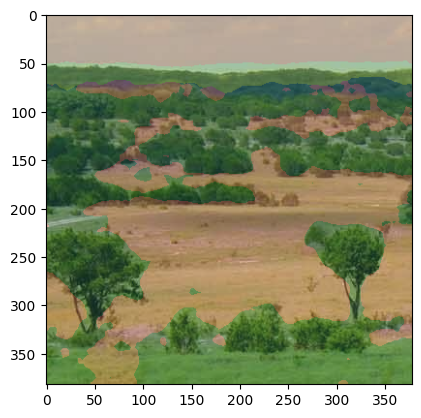

Ground Truth


/tmp/ipykernel_46767/1901739001.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


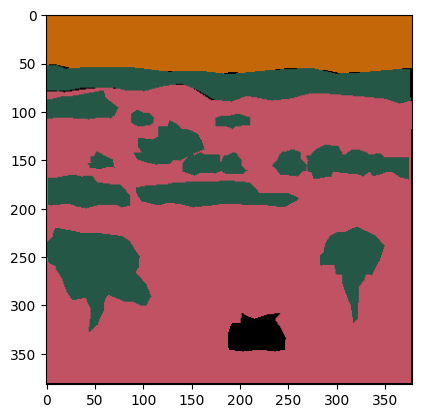

In [57]:
##Visualizing the mask and Ground truth

gt = np.array(Image.open("ADE_train_00007822.png"))



output = model(img_tensor)

_,predictions = output.squeeze().max(0)
preds = predictions.squeeze().cpu().numpy()

mask_map = lab_to_map(preds,N=150)
gt_map = lab_to_map(gt,N=150)

fig,ax = plt.subplots()

print("Predicted Mask: ")
ax.imshow(img)
ax.imshow(mask_map,alpha=0.4)
fig.show()
plt.show()

print("Ground Truth")
fig,ax = plt.subplots()

ax.imshow(img)
ax.imshow(gt_map,alpha=1)
fig.show()
plt.show()

### As an example, we will be visualizing the feature maps in the final segmentation classification layer, to understand how the maps for the top 5 classes look. 

**Things to keep in mind:**

1. Based on the sum of the feature map tensor, we will obtain the top 5 feature maps. This can be edited in the code based on user preference. 

<br>

2. There are 151 channels in the output of the final conv layer, assocciated with the 151 total classes in the dataset. In our case, we hope to see the top 5 classes predicted in the input Image


The model Conv layers are as follows: 
The layer name: backbone.low_level_features.0.0; The layer: Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
The layer name: backbone.low_level_features.1.conv.0.0; The layer: Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
The layer name: backbone.low_level_features.1.conv.1; The layer: Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
The layer name: backbone.low_level_features.2.conv.0.0; The layer: Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
The layer name: backbone.low_level_features.2.conv.1.0; The layer: Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), groups=96, bias=False)
The layer name: backbone.low_level_features.2.conv.2; The layer: Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
The layer name: backbone.low_level_features.3.conv.0.0; The layer: Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
The layer name: backbone.low_level_features.3.c

Enter name of the layer you wish to visualize: classifier.classifier.3
Layer:  classifier.classifier.3
Number of feature maps in the layer:  151
Top 5 feature maps:  [14  5 10 17 30]


Map index:  14


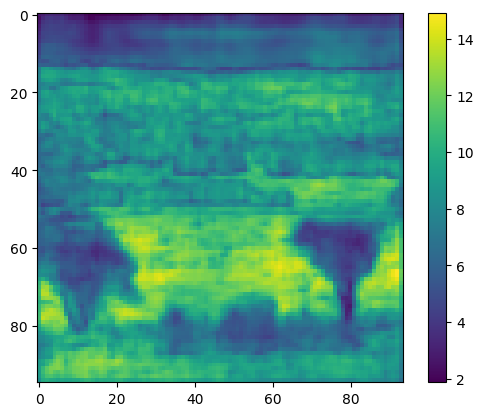



Map index:  5


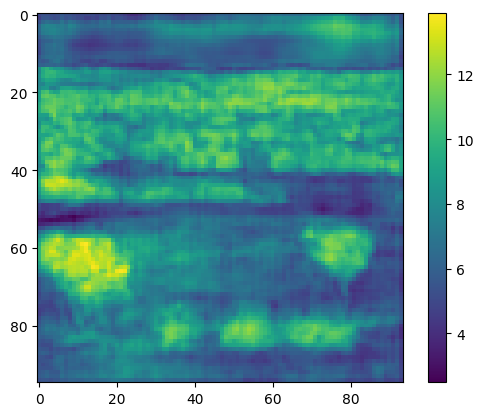



Map index:  10


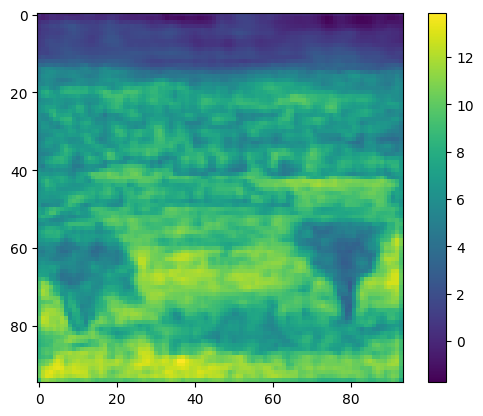



Map index:  17


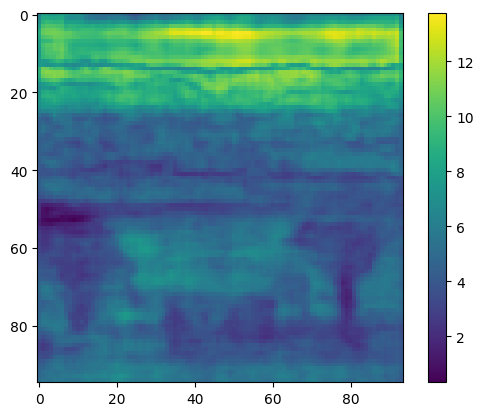



Map index:  30


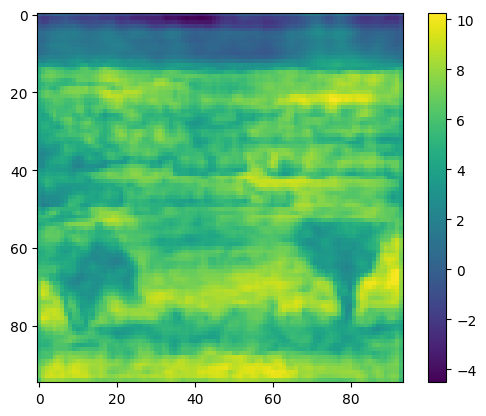

In [5]:
## Importing the visualizer 
from visualizer import visualizer

visualizer(model,img_tensor)

**A good illustration of how conv nets work can be seen using this example:**

Let us take the feature map under map index 14. Basically, this corresponds to class number 14 in the ADE20k dataset, which is the **Earth/Ground** class. As we can see in the previously printed segmentation mask, the class is basically the patches of brown on the lower and middle part of the image. **The patches in light brown have a high value in 14th channel of the output map from the Deeplabv3plus model**

<br>

Another feature map that gets mentioned is the one with map index 10; this corresponds to the **Grass** class. But, since this overlaps highly with the **Ground** class, it doesn't appear in the segmentation mask. The **Sky** class, which is very clearly visible in orange in the segmentation map, doesn't make its appearance in the top 5 even though its visible in the segmentation mask -- just some food for thought!

### Further Analysis

**This analysis led me into another string of thought: Does mIoU really give a proper perspective of the accuracy of the model?**

For example, in the above statement, classes **Grass** and **Ground** can easily be interchanged by even humans. The annotator's biases can easily seep into a model, leading us to question if the model is really as accurate or in-accurate as we think.

In [34]:
from sklearn.metrics import confusion_matrix

In [36]:
labels = [i for i in range(151)]

y_true = gt.flatten()
y_pred = preds.flatten()
print("Unique classes in predicted: ",np.unique(y_pred))
print("Unique classes in gt: ",np.unique(y_true))
matrix = confusion_matrix(y_true=y_true,y_pred=y_pred,labels=labels)

#row is the truth and column is the pred. Let us take the class 14
print(matrix[14,:])


Unique classes in predicted:  [ 3  5 10 14 17]
Unique classes in gt:  [ 0  3  5 14]
[    0     0     0     0     0 22644     0     0     0     0 16158     0
     0     0 48099     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

The classes being predicted instead of earth are tree and grass -- and resonable counter can be made that the model doesn't predict wrong at all

In [44]:
##Now, lets us create a custom map, where, whenever the gt is 14, we keep the value in the prediction array; this will be our
##new map. We will visualize this new map with our image 
gt_14 = np.zeros(preds.shape)
gt_14[gt == 14] = 14 

preds_14 = np.zeros(preds.shape)
preds_14[gt_14 == 14] = preds[gt_14 == 14]


difference = np.zeros(preds.shape)
difference[gt_14 != preds_14] = preds[gt_14 != preds_14]

print("Classes predicted instead of GT of 14: ",np.unique(difference))

Classes predicted instead of GT of 14:  [ 0.  5. 10.]


Areas Not predicted as ground but tree 


/tmp/ipykernel_46767/189606682.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


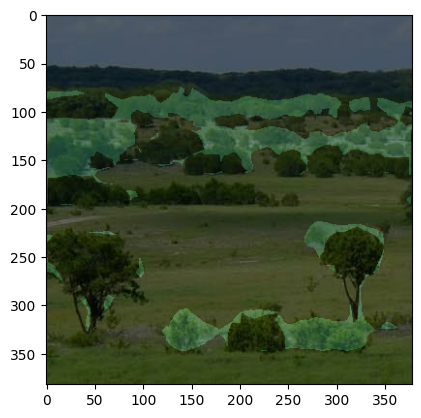

Areas Not predicted as ground but grass 


/tmp/ipykernel_46767/189606682.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


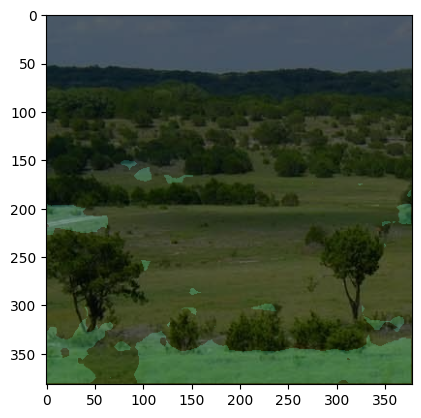

In [56]:

tree = np.zeros(difference.shape)
tree[difference == 5] = 5
tree_map = lab_to_map(tree)

grass = np.zeros(difference.shape)
grass[difference == 10] = 10
grass_map = lab_to_map(grass)

fig,ax = plt.subplots()

print("Areas Not predicted as ground but tree ")
ax.imshow(img)
ax.imshow(tree_map,alpha=0.6)
fig.show()
plt.show()



fig,ax = plt.subplots()

print("Areas Not predicted as ground but grass ")
ax.imshow(img)
ax.imshow(grass_map,alpha=0.6)
fig.show()
plt.show()


**These maps further strengthen my point**